[refer1](https://enjoymachinelearning.com/blog/k-means-accuracy-python-silhouette/?expand_article=1)
[refer2](https://www.askpython.com/python/examples/plot-k-means-clusters-python)

In [1]:
# !pip install -q umap        #-- for google colab
%pip install -q umap          #-- for vscode

Note: you may need to restart the kernel to use updated packages.


In [2]:
# !pip install -q yellowbrick    #-- for google colab
%pip install -q yellowbrick      #-- for vscode

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples,silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
# import data
# df = pd.read_csv('/content/Block2C_df.csv')
df= pd.read_csv('./Block2C_df.csv')
df

,Unnamed: 0,Year,Quarter,Year_Quarter,LGA,Sex,Age_Gr,TB_Cases
0,0,2019,1,2019 Q1,Birnin-Gwari,Male,0 to 4,0
1,1,2019,1,2019 Q1,Birnin-Gwari,Female,0 to 4,0
2,2,2019,2,2019 Q2,Birnin-Gwari,Male,0 to 4,0
3,3,2019,2,2019 Q2,Birnin-Gwari,Female,0 to 4,0
4,4,2019,3,2019 Q3,Birnin-Gwari,Male,0 to 4,0
...,...,...,...,...,...,...,...,...
7355,7355,2023,2,2023 Q2,Zaria,Female,> 65,20
7356,7356,2023,3,2023 Q3,Zaria,Male,> 65,18
7357,7357,2023,3,2023 Q3,Zaria,Female,> 65,49
7358,7358,2023,4,2023 Q4,Zaria,Male,> 65,34


In [6]:
# drop index column created by pandas
df.drop(columns=['Unnamed: 0','Year_Quarter'],inplace=True)

performed basic EDA to verify if data is same as the result of EDA stage or not

## Basic EDA

In [7]:
df2 = df.copy()

In [8]:
#Check for Null values
df2.isnull().sum()

Year        0
Quarter     0
LGA         0
Sex         0
Age_Gr      0
TB_Cases    0
dtype: int64

there are no null values as they are been handled during EDA stage.

In [9]:
# summary statistic for numerical variables
df2.describe()

,Year,Quarter,TB_Cases
count,7360.00000,7360.00000,7360.000000
mean,2021.00000,2.50000,10.128804
std,1.41431,1.11811,19.474332
min,2019.00000,1.00000,0.000000
25%,2020.00000,1.75000,1.000000
50%,2021.00000,2.50000,3.000000
75%,2022.00000,3.25000,10.000000
max,2023.00000,4.00000,215.000000


In [10]:
# check unique values present in each column
df2.nunique()

Year          5
Quarter       4
LGA          23
Sex           2
Age_Gr        8
TB_Cases    142
dtype: int64

In [11]:
# check for outliers in TB_Cases
len(df2[df2['TB_Cases']>10])

1760

In [12]:
outliers = df2[df2['TB_Cases']>10]

In [13]:
outliers

,Year,Quarter,LGA,Sex,Age_Gr,TB_Cases
200,2020,1,Giwa,Male,0 to 4,14
206,2020,4,Giwa,Male,0 to 4,14
386,2021,2,Giwa,Male,0 to 4,11
570,2022,2,Giwa,Male,0 to 4,15
572,2022,3,Giwa,Male,0 to 4,28
...,...,...,...,...,...,...
7355,2023,2,Zaria,Female,> 65,20
7356,2023,3,Zaria,Male,> 65,18
7357,2023,3,Zaria,Female,> 65,49
7358,2023,4,Zaria,Male,> 65,34


<AxesSubplot:xlabel='TB_Cases'>

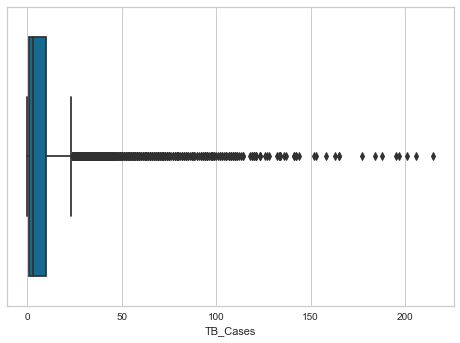

In [14]:
sns.boxplot(df2.TB_Cases)

<AxesSubplot:>

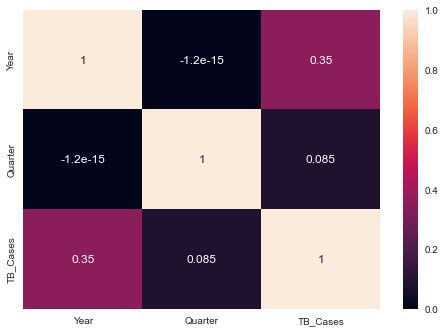

In [15]:
# checking if any features are correlated with each other
corr = df2.corr()
sns.heatmap(corr,annot=True)

## Preprocessing

In [16]:
df2_le = df2.copy()

changed categorical columns i.e. LGA, Sex and Age_Gr into numerical type using appropriate methods

In [17]:
# LabelEncoder is used for LGA as column contains more than 10 unique variables.
le = LabelEncoder()
df2_le['LGA'] = le.fit_transform(df2_le['LGA'])
print(df2_le['LGA'].unique())

# Simple replace method for Sex as column contains only two unique variables
df2_le['Sex'] = df2_le['Sex'].replace(['Male','Female'],[1,0])

# OneHotEncoder(pandas) is used for Age_Gr as column contains less than 10 unique variables
df2_age_oh = pd.get_dummies(df2_le['Age_Gr'])
print(df2_age_oh)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
      0 to 4  15 to 24  25 to 34  35 to 44  45 to 54  5 to 14  55 to 64  > 65
0          1         0         0         0         0        0         0     0
1          1         0         0         0         0        0         0     0
2          1         0         0         0         0        0         0     0
3          1         0         0         0         0        0         0     0
4          1         0         0         0         0        0         0     0
...      ...       ...       ...       ...       ...      ...       ...   ...
7355       0         0         0         0         0        0         0     1
7356       0         0         0         0         0        0         0     1
7357       0         0         0         0         0        0         0     1
7358       0         0         0         0         0        0         0     1
7359       0         0         0         0         0        0         0

In [18]:
# dropped original column Age_Gr
df2_le_copy = df2_le.drop(columns=['Age_Gr'])

# added one-hot encoded columns to preprocessed data
df2_oh = df2_le_copy.join(df2_age_oh)

In [19]:
df2_oh.head()

,Year,Quarter,LGA,Sex,TB_Cases,0 to 4,15 to 24,25 to 34,35 to 44,45 to 54,5 to 14,55 to 64,> 65
0,2019,1,0,1,0,1,0,0,0,0,0,0,0
1,2019,1,0,0,0,1,0,0,0,0,0,0,0
2,2019,2,0,1,0,1,0,0,0,0,0,0,0
3,2019,2,0,0,0,1,0,0,0,0,0,0,0
4,2019,3,0,1,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

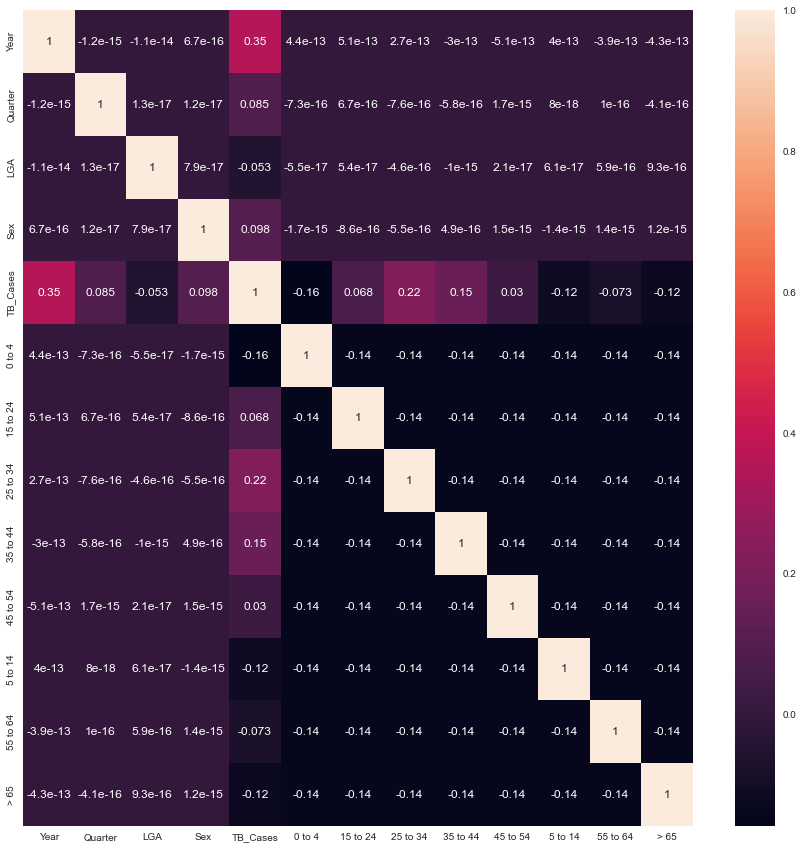

In [20]:
# checked if newly created features are correlated or not
fig  = plt.figure(figsize=(15,15))
corr = df2_oh.corr()
sns.heatmap(corr,annot=True)

In clustering, the distance between different points is evaluation criteria, So scale of data plays significant role. It is necessary to standardise data before applying clustering model.

In [21]:
ss_scaler = StandardScaler()
df2_ss_scaled = ss_scaler.fit_transform(df2_oh)

In [22]:
df2_ss_scaled

array([[-1.41421356, -1.34164079, -1.6583124 , ..., -0.37796447,
        -0.37796447, -0.37796447],
       [-1.41421356, -1.34164079, -1.6583124 , ..., -0.37796447,
        -0.37796447, -0.37796447],
       [-1.41421356, -0.4472136 , -1.6583124 , ..., -0.37796447,
        -0.37796447, -0.37796447],
       ...,
       [ 1.41421356,  0.4472136 ,  1.6583124 , ..., -0.37796447,
        -0.37796447,  2.64575131],
       [ 1.41421356,  1.34164079,  1.6583124 , ..., -0.37796447,
        -0.37796447,  2.64575131],
       [ 1.41421356,  1.34164079,  1.6583124 , ..., -0.37796447,
        -0.37796447,  2.64575131]])

In [23]:
# Standardised the data
mm_scaler = MinMaxScaler()
df2_mm_scaled = mm_scaler.fit_transform(df2_oh)

In [24]:
df2_mm_scaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.66666667, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

## Model

#### K-Means Clustering

<p>In K-means, <strong>K stands for no. of clusters</strong> and is the most vital parameter for performance of the algorithm.</p>
<p>The easiest way to find K in K Means is by using the <strong>elbow method</strong>. Plot the inertia at many different values of K. When the graph looks like an elbow, select that as an initial K value moving forward. This value K will need to be validated.</p>

In [25]:
model = KMeans(init='k-means++',max_iter=300,n_init=10,random_state=32)
visualizer = KElbowVisualizer(model,k=(3,10))

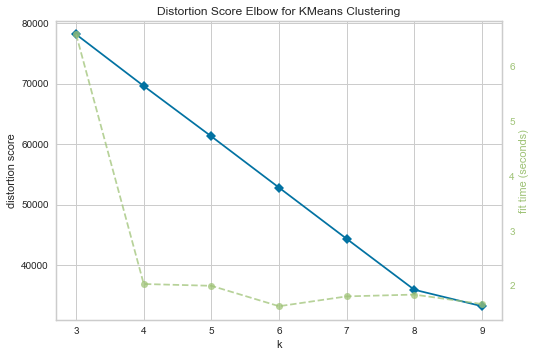

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
visualizer.fit(df2_ss_scaled)
visualizer.show()

In [27]:
visualizer.fit(df2_mm_scaled)
visualizer.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

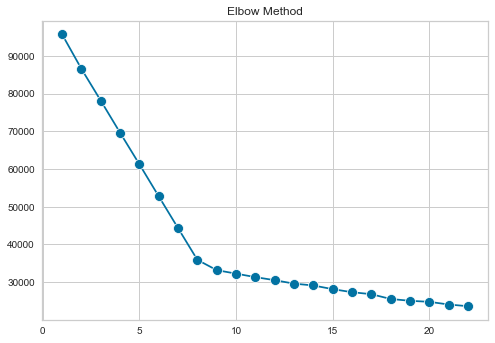

In [28]:
# created container to store all possible inertias
inertia = []

# applied KMeans with k within range of 1 to 22 as maximum unique values present in the data[LGA].
for i in range(1,23):
  model = KMeans(n_clusters=i,init='k-means++',random_state=20)
  model.fit(df2_ss_scaled)
  inertia.append(model.inertia_)

# plotted the inertias at different values of k
sns.lineplot(x = range(1,23),
         y =inertia,
         marker = 'o',
         markersize=10)
plt.title('Elbow Method')
plt.show()

There seems to be two possible candidates for Elbow values i.e. **8 and 16** also every value after 8 seems like a good choice at a glance.
<p> So, to find the optimal number of k to use for final clustering we will be using metric called <strong>silhouette score</strong></p>

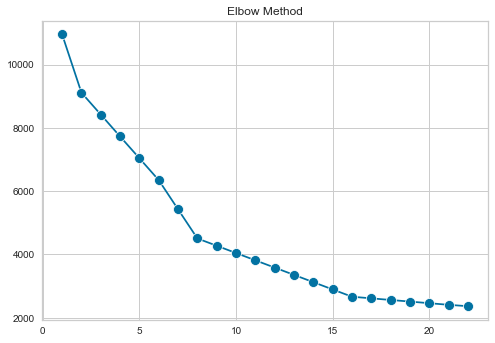

In [29]:
inertia = []

# applied KMeans with k within range of 1 to 22 as maximum unique values present in the data[LGA].
for i in range(1,23):
  model = KMeans(n_clusters=i,init='k-means++',random_state=20)
  model.fit(df2_mm_scaled)
  inertia.append(model.inertia_)

# plotted the inertias at different values of k
sns.lineplot(x = range(1,23),
         y =inertia,
         marker = 'o',
         markersize=10)
plt.title('Elbow Method')
plt.show()

The **Silhouette score** in the K-Means clustering algorithm is **between -1 and 1**. This score represents how well the data point has been clustered, and scores above 0 are seen as good, while **negative points** mean your K-means algorithm has put that **data point in the wrong cluster**.

In [30]:
# let's check model performance for one of the candidate point.
# k=20
model = KMeans(n_clusters=20, init='k-means++',random_state=20)

# re-fit our model
model.fit(df2_ss_scaled)

# compute an average silhouette score for each point
silhouette_score_average = silhouette_score(df2_ss_scaled, model.predict(df2_ss_scaled))

# lets see what that score it
print(silhouette_score_average)

0.22490302239024043


In [31]:
# while that's nice, what does that tell us? there could still be a points with a negative value

# let's see the points
silhouette_score_individual = silhouette_samples(df2_ss_scaled, model.predict(df2_ss_scaled))


# iterate through to find any negative values
for each_value in silhouette_score_individual:
    if each_value < 0:
        print(f'We have found a negative silhouette score: {each_value}')

We have found a negative silhouette score: -0.0026501540653463634
We have found a negative silhouette score: -0.017059847554247668
We have found a negative silhouette score: -0.010036853000765322
We have found a negative silhouette score: -0.005812828824927856
We have found a negative silhouette score: -0.015744032156093924
We have found a negative silhouette score: -0.028562203524010423
We have found a negative silhouette score: -0.0016572242074572312
We have found a negative silhouette score: -0.018190759684491895
We have found a negative silhouette score: -0.011389947143043293
We have found a negative silhouette score: -0.005961855174697708
We have found a negative silhouette score: -0.01840269104582561
We have found a negative silhouette score: -0.03425033162266816
We have found a negative silhouette score: -0.0006959639240414636
We have found a negative silhouette score: -0.018029287401838495
We have found a negative silhouette score: -0.01139767775672172
We have found a negative 

As we can see. there are lot of negative individual scores. so having only good silhouette score is not ideal we need to minimize count of negative values also.

lets check for other k-candidates also

In [32]:
bad_k_values = {}
silhouette_scores = {}
for i in range(8,23):
  model = KMeans(n_clusters=i,init='k-means++',random_state=20)
  model.fit(df2_ss_scaled)
  silhouette_scores[i]= silhouette_score(df2_ss_scaled,model.predict(df2_ss_scaled))

  silhouette_score_individual = silhouette_samples(df2_ss_scaled,model.predict(df2_ss_scaled))

  # iterate through to find any negative values
  print("k = ", i,":")

  for score in silhouette_score_individual:
    if score <0:
      if i not in bad_k_values:
        bad_k_values[i]= 1
      else:
        bad_k_values[i] +=1

k =  8 :
k =  9 :
k =  10 :
k =  11 :
k =  12 :
k =  13 :
k =  14 :
k =  15 :
k =  16 :
k =  17 :
k =  18 :
k =  19 :
k =  20 :
k =  21 :
k =  22 :


In [33]:
print(bad_k_values)
print(silhouette_scores)

{8: 1, 9: 45, 10: 43, 11: 50, 12: 83, 13: 82, 14: 65, 15: 54, 16: 49, 17: 64, 18: 65, 19: 40, 20: 94, 21: 55, 22: 78}
{8: 0.43775433471801817, 9: 0.44509236267279284, 10: 0.40316558619380255, 11: 0.37818865761535925, 12: 0.3526664810143865, 13: 0.3292309054441699, 14: 0.28545796319419664, 15: 0.2703331210855751, 16: 0.24200288981132692, 17: 0.24606820536324334, 18: 0.2363056988826531, 19: 0.23448657453649677, 20: 0.22490302239024043, 21: 0.23194881062949518, 22: 0.23960379688041786}


while k=9 have highest silhouette avg. the negative score count is significant compared to k=8 with second highest silhouette score and with one negative individual score.

So. we will use k=8 for our model

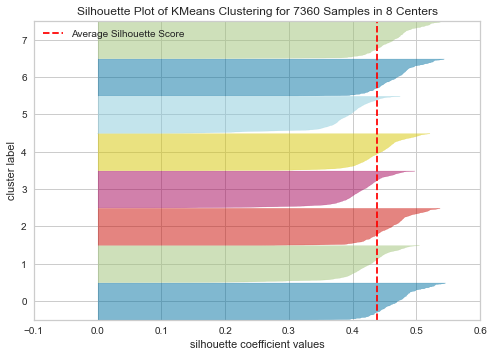

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 7360 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(8, init='k-means++', max_iter=300, n_init=10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(df2_ss_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [35]:
bad_k_values = {}
silhouette_scores = {}
for i in range(8,23):
  model = KMeans(n_clusters=i,init='k-means++',random_state=20)
  model.fit(df2_mm_scaled)
  silhouette_scores[i]= silhouette_score(df2_mm_scaled,model.predict(df2_mm_scaled))

  silhouette_score_individual = silhouette_samples(df2_mm_scaled,model.predict(df2_mm_scaled))

  # iterate through to find any negative values
  print("k = ", i,":")

  for score in silhouette_score_individual:
    if score <0:
      if i not in bad_k_values:
        bad_k_values[i]= 1
      else:
        bad_k_values[i] +=1

k =  8 :
k =  9 :
k =  10 :
k =  11 :
k =  12 :
k =  13 :
k =  14 :
k =  15 :
k =  16 :
k =  17 :
k =  18 :
k =  19 :
k =  20 :
k =  21 :
k =  22 :


In [36]:
print(bad_k_values)
print(silhouette_scores)

{}
{8: 0.4121305454833786, 9: 0.3657081571417639, 10: 0.3687729716112668, 11: 0.37200340090856726, 12: 0.3752237962165977, 13: 0.3782835330330226, 14: 0.3816953327853826, 15: 0.3851065917695081, 16: 0.3885376914682366, 17: 0.3796673861923959, 18: 0.37051348277314866, 19: 0.36177248321789374, 20: 0.35279179361885615, 21: 0.34400208121747916, 22: 0.3384632659876215}


In [37]:
# final clustering using optimal k
final_model = KMeans(n_clusters=8,init='k-means++',random_state=20)
final_model.fit(df2_ss_scaled)
labels = final_model.labels_

In [38]:
final_model.fit(df2_mm_scaled)
mm_labels = final_model.labels_

In [39]:
df_final = df2_oh.copy()
df_final['km_ss_clusters'] = labels
df_final['km_mm_clusters'] = mm_labels

# df_final.head()

#### DBCSAN

[refer1](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/)

In [43]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df2_ss_scaled)
distances, indices = nbrs.kneighbors(df2_ss_scaled)

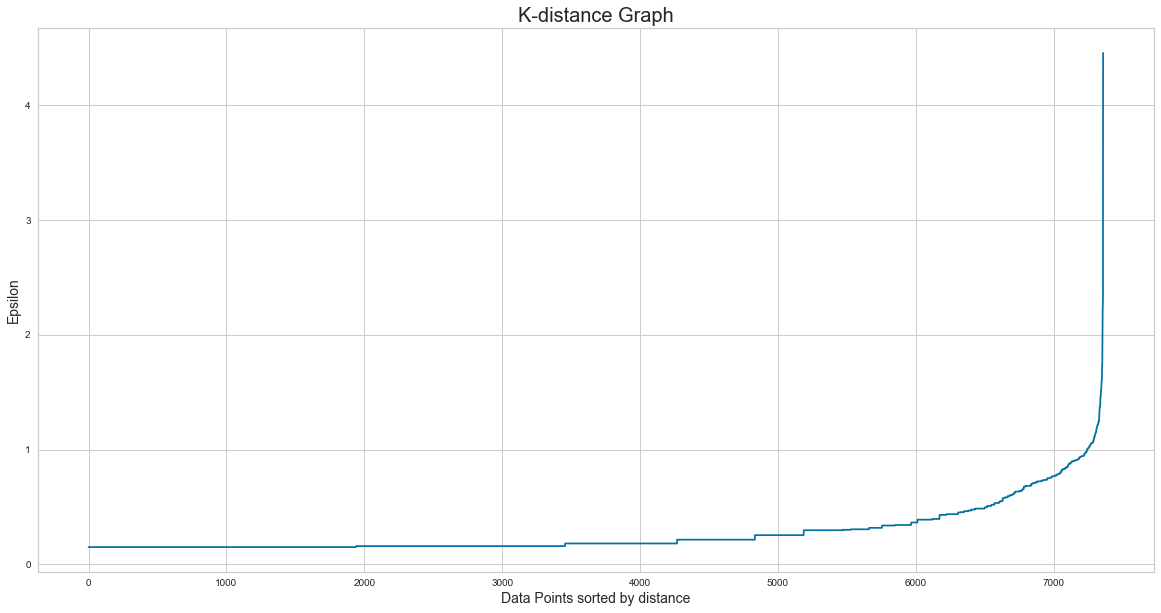

In [44]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
# plt.yticks(minor=True)
plt.show()

In [45]:
def tune_dbscan(data,eps_values,min_samples_values):
  best_score = -1
  best_params = None
  best_labels = None

  for eps in eps_values:
    for min_samples in min_samples_values:
      model = DBSCAN(eps=eps,min_samples=min_samples)
      labels = model.fit_predict(data)

      if len(np.unique(labels)) >1:
        score = silhouette_score(data,labels)
        if score > best_score:
          best_score=score
          best_params = {'eps':eps,'min_samples':min_samples}
          best_labels=labels

  return best_params, best_score, best_labels

In [46]:
eps_values = [0.7,0.8,0.9,1.0,1.1]
min_samples_values= [13,15,18,20,22,24]
best_ss_params, best_ss_score, best_ss_labels = tune_dbscan(df2_ss_scaled,eps_values,min_samples_values)

In [47]:
print(best_ss_params)
print(best_ss_score)

{'eps': 1.1, 'min_samples': 13}
0.2283696647936841


In [48]:
eps_values = [0.7,0.8,0.9,1.0,1.1]
min_samples_values= [13,15,18,20,22,24]
best_mm_params, best_mm_score, best_mm_labels = tune_dbscan(df2_mm_scaled,eps_values,min_samples_values)

In [49]:
print(best_mm_params)
print(best_mm_score)

{'eps': 1.0, 'min_samples': 13}
0.4121305454833786


In [50]:
df_final['db_ss_clusters'] = best_ss_labels
df_final['db_mm_clusters'] = best_mm_labels

#### GMM

[refer1](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

In [51]:
gm_aic =[]
gm_bic =[]
gm_score =[]

for i in range(2,23):
  gm = GaussianMixture(n_components=i,n_init=10,init_params='k-means++',max_iter=400,random_state=19).fit(df2_ss_scaled)
  gm_bic.append(gm.bic(df2_ss_scaled))
  gm_aic.append(gm.aic(df2_ss_scaled))
  print(f'Log-likelihood score for {i} clusters : {gm.score(df2_ss_scaled)}')

Log-likelihood score for 2 clusters : 17.03640548465611
Log-likelihood score for 3 clusters : 26.0832688285719
Log-likelihood score for 4 clusters : 31.707137222390575
Log-likelihood score for 5 clusters : 33.57946221545599
Log-likelihood score for 6 clusters : 35.41478118660317
Log-likelihood score for 7 clusters : 37.33371050176252
Log-likelihood score for 8 clusters : 39.207453744176085
Log-likelihood score for 9 clusters : 39.405414936879005
Log-likelihood score for 10 clusters : 40.89199988276131
Log-likelihood score for 11 clusters : 40.996665460374075
Log-likelihood score for 12 clusters : 41.40763707730683
Log-likelihood score for 13 clusters : 41.303422772825684
Log-likelihood score for 14 clusters : 42.012614939058196
Log-likelihood score for 15 clusters : 42.38452753259639
Log-likelihood score for 16 clusters : 42.84205348524429
Log-likelihood score for 17 clusters : 43.30549756484479
Log-likelihood score for 18 clusters : 43.27585750974978
Log-likelihood score for 19 cluste

In [52]:
print(gm_aic)
print(gm_bic)

[-250357.88873413796, -383317.7171565784, -465891.05991358927, -493241.6838115122, -520047.5790667987, -548084.2185859443, -575455.7191142719, -578159.707870859, -599832.2382742465, -601162.9155767064, -607002.4177779566, -605258.3832159941, -615487.6919029367, -620752.2452798188, -627277.027302796, -633888.9241545154, -633242.6225435167, -627875.1760408278, -664099.5735528071, -653177.8146060987, -658603.6272687715]
[-248914.99135488787, -381149.9191800974, -462998.36133987736, -489624.0846405694, -515705.07929862494, -543016.8182205396, -569663.4181516364, -571642.5063109925, -592590.1361171491, -593195.9128223781, -598310.5144263974, -595841.579267204, -605345.9873569157, -609885.640136567, -615685.5215623132, -621572.5178168017, -620201.3156085721, -614108.9685086523, -649608.4654234006, -637961.8058794613, -642662.7179449033]


In [53]:
gm_ss = GaussianMixture(n_components=8,
                     n_init=10,
                     covariance_type="full",
                     init_params="k-means++",
                     max_iter=400,
                     random_state=28).fit(df2_ss_scaled)

pred_gm_ss = gm_ss.predict(df2_ss_scaled)

In [54]:
gm_mm = GaussianMixture(n_components=8,
                     n_init=10,
                     covariance_type="full",
                     init_params="k-means++",
                     max_iter=400,
                     random_state=28).fit(df2_mm_scaled)

pred_gm_mm = gm_ss.predict(df2_mm_scaled)

In [55]:
print("for StandardScaler, Silhouette Score:",silhouette_score(df2_ss_scaled,pred_gm_ss))
print("for MinMaxScaler, Silhouette Score:",silhouette_score(df2_mm_scaled,pred_gm_mm))

for StandardScaler, Silhouette Score: 0.4377348060376814
for MinMaxScaler, Silhouette Score: 0.4121305454833786


In [56]:
df_final['gm_ss_clusters'] = pred_gm_ss
df_final['gm_mm_clusters'] = pred_gm_mm

In [57]:
df_final[['km_ss_clusters','km_mm_clusters','db_ss_clusters','db_mm_clusters','gm_ss_clusters','gm_mm_clusters']].head()

,km_ss_clusters,km_mm_clusters,db_ss_clusters,db_mm_clusters,gm_ss_clusters,gm_mm_clusters
0,1,6,0,0,7,7
1,1,6,1,0,7,7
2,1,6,0,0,7,7
3,1,6,1,0,7,7
4,1,6,0,0,7,7
